## The Architecture

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

class Model_Down(nn.Module):
    """
    Convolutional (Downsampling) Blocks.

    nd = Number of Filters
    kd = Kernel size

    """
    def __init__(self,in_channels, nd = 128, kd = 3, padding = 1, stride = 2):
        super(Model_Down,self).__init__()
        self.padder = nn.ReflectionPad2d(padding)
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = nd, kernel_size = kd, stride = stride)
        self.bn1 = nn.BatchNorm2d(nd)

        self.conv2 = nn.Conv2d(in_channels = nd, out_channels = nd, kernel_size = kd, stride = 1)
        self.bn2 = nn.BatchNorm2d(nd)

        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.padder(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.padder(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x


class Model_Skip(nn.Module):
    """

    Skip Connections

    ns = Number of filters
    ks = Kernel size

    """
    def __init__(self,in_channels = 128, ns = 4, ks = 1, padding = 0, stride = 1):
        super(Model_Skip, self).__init__()
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = ns, kernel_size = ks, stride = stride, padding = padding)
        self.bn = nn.BatchNorm2d(ns)
        self.relu = nn.LeakyReLU()

    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Model_Up(nn.Module):
    """
    Convolutional (Downsampling) Blocks.

    nd = Number of Filters
    kd = Kernel size

    """
    def __init__(self, in_channels = 132, nu = 128, ku = 3, padding = 1):
        super(Model_Up, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.padder = nn.ReflectionPad2d(padding)
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = nu, kernel_size = ku, stride = 1, padding = 0)
        self.bn2 = nn.BatchNorm2d(nu)

        self.conv2 =  nn.Conv2d(in_channels = nu, out_channels = nu, kernel_size = 1, stride = 1, padding = 0) #According to supmat.pdf ku = 1 for second layer
        self.bn3 = nn.BatchNorm2d(nu)

        self.relu = nn.LeakyReLU()

    def forward(self,x):
        x = self.bn1(x)
        x = self.padder(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = F.interpolate(x, scale_factor = 2, mode = 'bilinear')
        return x


class Model(nn.Module):
    def __init__(self, length = 5, in_channels = 32, out_channels = 3, nu = [128,128,128,128,128] , nd =
                    [128,128,128,128,128], ns = [4,4,4,4,4], ku = [3,3,3,3,3], kd = [3,3,3,3,3], ks = [1,1,1,1,1]):
        super(Model,self).__init__()
        assert length == len(nu), 'Hyperparameters do not match network depth.'

        self.length = length

        self.downs = nn.ModuleList([Model_Down(in_channels = nd[i-1], nd = nd[i], kd = kd[i]) if i != 0 else
                                        Model_Down(in_channels = in_channels, nd = nd[i], kd = kd[i]) for i in range(self.length)])

        self.skips = nn.ModuleList([Model_Skip(in_channels = nd[i], ns = ns[i], ks = ks[i]) for i in range(self.length)])

        self.ups = nn.ModuleList([Model_Up(in_channels = ns[i]+nu[i+1], nu = nu[i], ku = ku[i]) if i != self.length-1 else
                                        Model_Up(in_channels = ns[i], nu = nu[i], ku = ku[i]) for i in range(self.length-1,-1,-1)]) #Elements ordered backwards

        self.conv_out = nn.Conv2d(nu[0],out_channels,1,padding = 0)
        self.sigm = nn.Sigmoid()

    def forward(self,x):
        s = [] #Skip Activations

        #Downpass
        for i in range(self.length):
            x = self.downs[i].forward(x)
            s.append(self.skips[i].forward(x))

        #Uppass
        for i in range(self.length):
            if (i == 0):
                x = self.ups[i].forward(s[-1])
            else:
                x = self.ups[i].forward(torch.cat([x,s[self.length-1-i]],axis = 1))

        x = self.sigm(self.conv_out(x)) #Squash to RGB ([0,1]) format
        return x


# Restoration Preprocessing

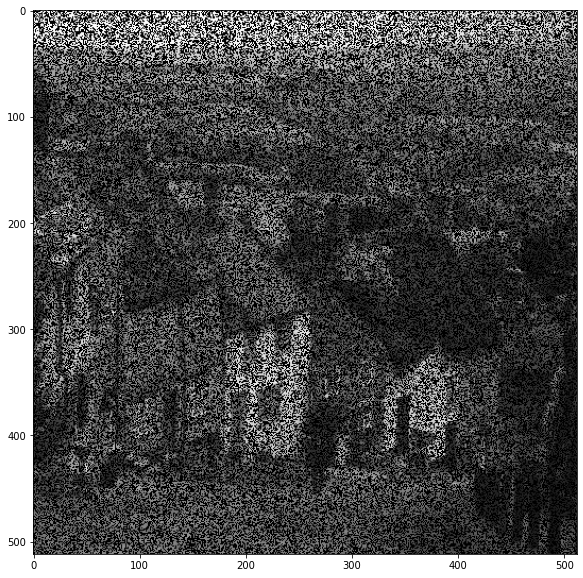

In [26]:
from scipy.sparse import random

im = Image.open('hill_GT.png')

im_np = np.array(im)
fig, ax = plt.subplots(figsize=(10,10))


mask_np = random(512,512,0.5,dtype = bool).A.astype(float)
plt.imshow(mask_np*im_np, cmap = 'gray')

mask_tensor = torch.from_numpy(mask_np)
im_tensor = torch.from_numpy(im_np)

im_masked_tensor = ((mask_tensor*im_tensor).unsqueeze(0).unsqueeze(0)/255).cuda()
mask_tensor = mask_tensor.unsqueeze(0).cuda()

## Input Initialization

In [0]:
z = (0.1) * torch.rand((1,32,512,512), device = "cuda")

#Meshgrid Input
#sym = np.arange(0,512)
#xv, yv = np.meshgrid(sym,sym)
#xv = xv/(255.0)
#yv = yv/(255.0)
#z =np.stack([xv,yv])
#z = torch.from_numpy(z)
#z = torch.tensor(z.unsqueeze(0), device = 'cuda', dtype = torch.float32)

net = Model(out_channels = 1)
optimizer = torch.optim.Adam(net.parameters(),lr = 0.0005)

net = net.cuda()

## PSNR function

In [0]:
from math import log10, sqrt
def PSNR(orig, new,maxpix): 
    mse = np.mean((orig - new) ** 2)
    #print("MSE" + str(mse))
    psnr = 20 * log10(maxpix / sqrt(mse)) 
    return psnr

## Main Loop

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


EPOCH: 0
LOSS: 0.023044133080859515
PSNR: 27.94402929691543



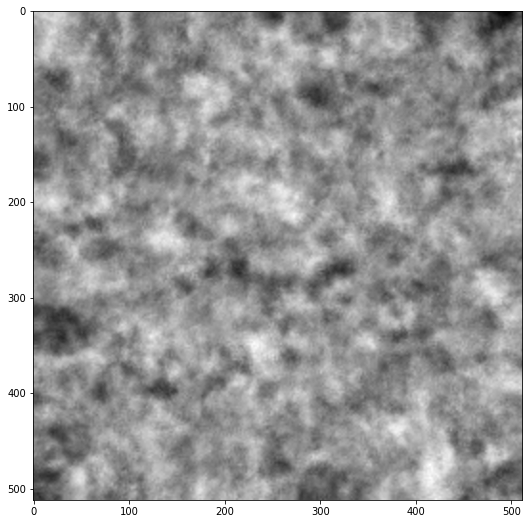

EPOCH: 1000
LOSS: 0.0005027382273064715
PSNR: 31.64018958913536



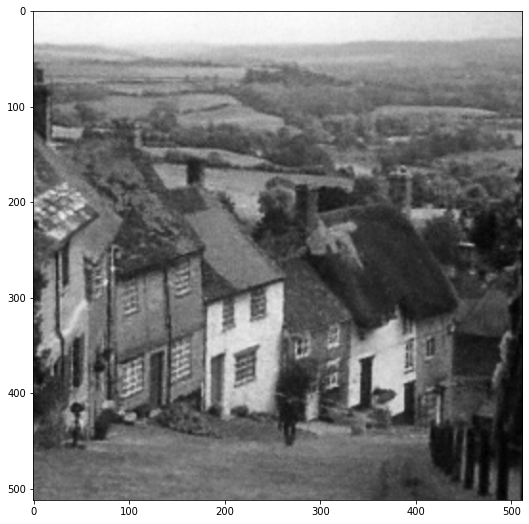

EPOCH: 2000
LOSS: 0.0003458205099020349
PSNR: 32.278592522544834



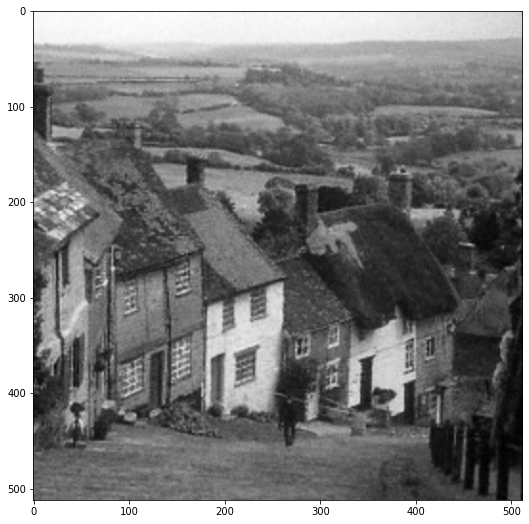

EPOCH: 3000
LOSS: 0.00029551563663017446
PSNR: 32.540193487587395



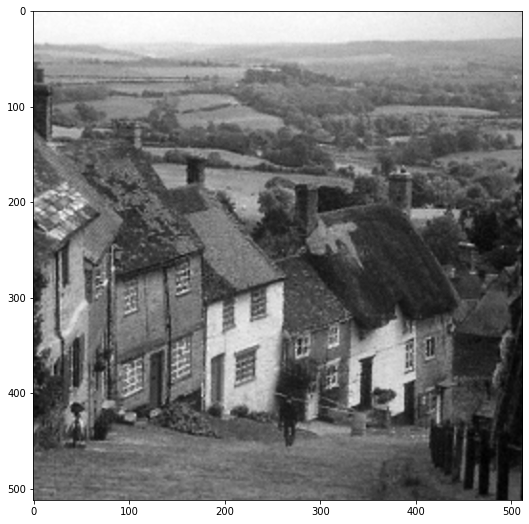

EPOCH: 4000
LOSS: 0.0002454615127220867
PSNR: 32.88558892309528



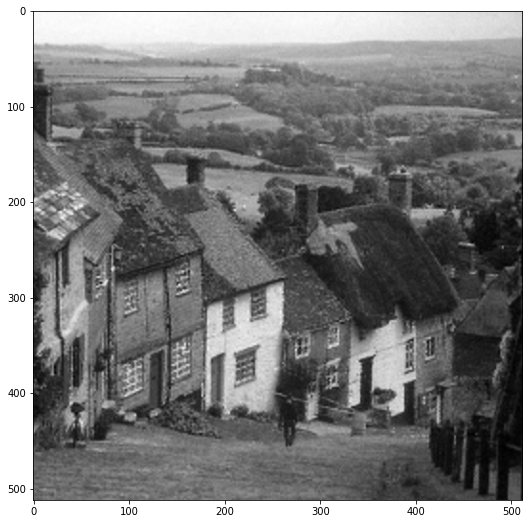

EPOCH: 5000
LOSS: 0.0005336944379962626
PSNR: 31.67566450336063



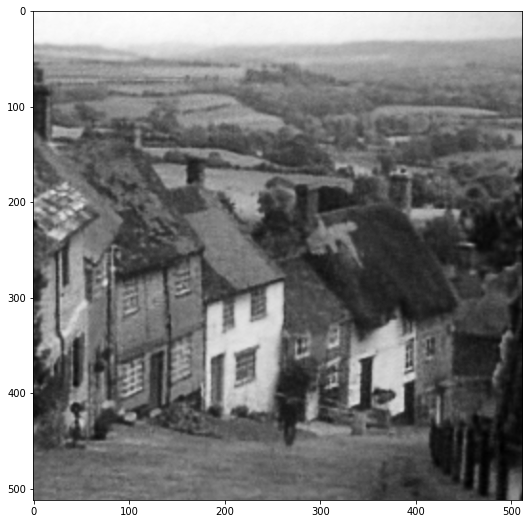

EPOCH: 6000
LOSS: 0.00026401773251019407
PSNR: 32.81149886287204



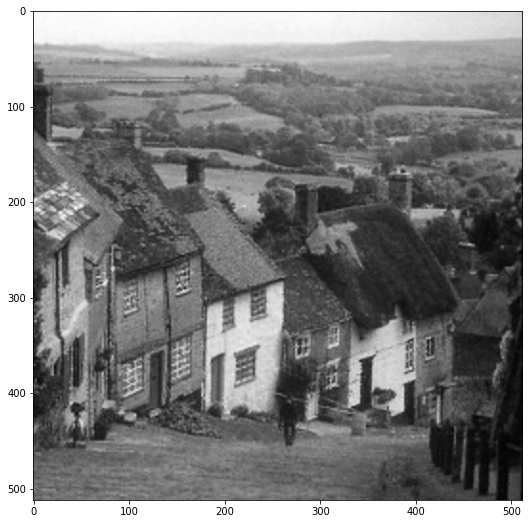

EPOCH: 7000
LOSS: 0.00022963150460741683
PSNR: 33.011238053179035



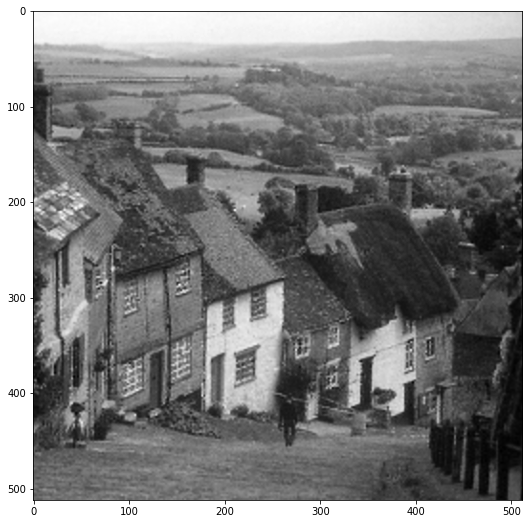

EPOCH: 8000
LOSS: 0.00021532407152516424
PSNR: 33.04585934935445



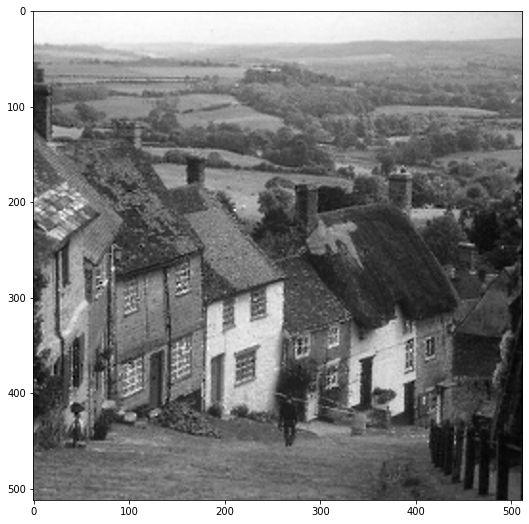

EPOCH: 9000
LOSS: 0.00020689154869660902
PSNR: 33.048867870711966



EPOCH: 10000
LOSS: 0.0002093802235968985
PSNR: 32.99798652181961



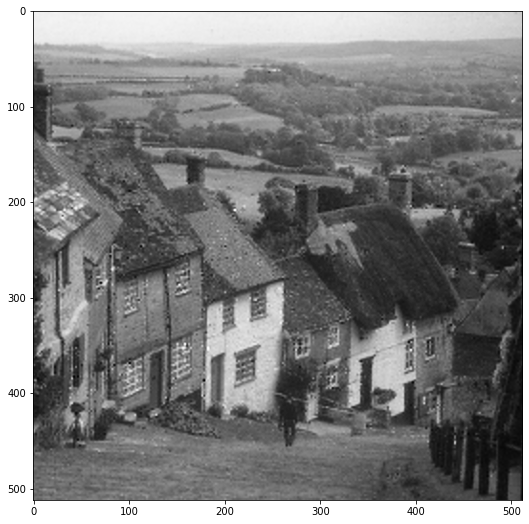

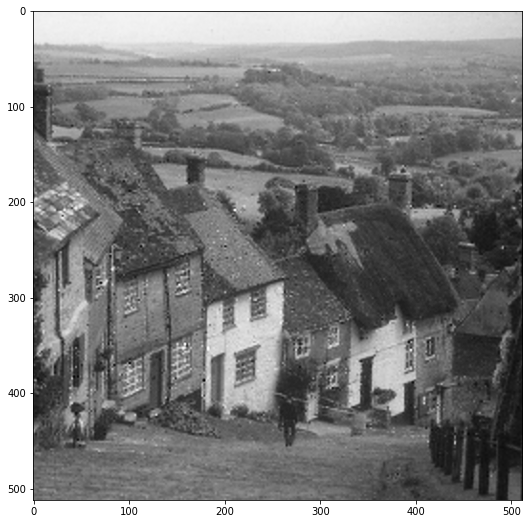

In [29]:
#Main Loop (same as above)
plt.rcParams["figure.figsize"] = (9,9)

for epoch in range(11000):
    
    optimizer.zero_grad()
    output = net.forward(z)
    loss = F.mse_loss(output*mask_tensor, im_masked_tensor)

    psnr = PSNR(np.uint8(output.cpu().view(512,512).detach().numpy()*255), im_np,255)
    if(epoch==0):
      psnr_last = psnr

    if (epoch % 1000 == 0):
      print('EPOCH: ' + str(epoch))
      print('LOSS: ' + str(loss.item()))
      print('PSNR: ' +str(psnr), end = '\n\n')
      plt.imshow(output.cpu().view(512,512).detach().numpy(),cmap = 'gray')
      plt.show()

    loss.backward()
    optimizer.step()

    z = z + (1/30)*torch.randn_like(z)

plt.imshow(output.cpu().view(512,512).detach().numpy(),cmap = 'gray')


In [32]:
#Final PSNR
print(psnr)

33.032642768608966
